### Imports

In [15]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

import time
import os
import sys
import matplotlib.pyplot as plt
import torch.optim as optim
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
torch.set_default_dtype(torch.float32)
sys.path.append("..")

from utils.data_utils import read_data_sets
from optim.FishLeg import FishLeg, FISH_LIKELIHOODS, initialise_FishModel
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

### Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### MNIST Dataset

In [3]:

dataset = read_data_sets("MNIST", "./data/", if_autoencoder=True)

train_dataset = dataset.train
test_dataset = dataset.test

Begin loading data for MNIST
Data read from ./data/data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./data/data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./data/data/MNIST_data/t10k-images-idx3-ubyte.gz
Data read from ./data/data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./data/data/MNIST_data/train-labels-idx1-ubyte.gz


Extracting ./data/data/MNIST_data/t10k-labels-idx1-ubyte.gz
Succesfully loaded MNIST dataset.


#### Data Preparation

In [5]:
batch_size = 100

# For training θ 
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)),
)

# For training λ (auxiliary parameter)
aux_loader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)),
)

# for testing
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1000,
    shuffle=False,
    collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)),
)

### NN

In [6]:
model = nn.Sequential(
    nn.Linear(784, 1000, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(1000, 500, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(500, 250, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(250, 30, dtype=torch.float32),
    nn.Linear(30, 250, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(250, 500, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(500, 1000, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(1000, 784, dtype=torch.float32),
)

model = model.to(device)

### Loss

In [7]:
likelihood = FISH_LIKELIHOODS["bernoulli"](device=device)

## FishLeg

#### Optimizer

##### Params

In [11]:
eta_adam = 1e-4

lr = 0.005
beta = 0.9
weight_decay = 1e-5

aux_lr = 1e-4
aux_eps = 1e-8
scale_factor = 1
damping = 0.1
update_aux_every = 10

initialization = "normal"
normalization = True


##### NN Reinitialization

In [12]:
model = initialise_FishModel(
    model, module_names="__ALL__", fish_scale=scale_factor / damping
)

model = model.to(device)

##### Writter

In [13]:

writer = SummaryWriter(
    log_dir=f"runs/MNIST_fishleg/lr={lr}_auxlr={aux_lr}/{datetime.now().strftime('%Y%m%d-%H%M%S')}",
)

In [16]:
opt = FishLeg(
    model,
    aux_loader,
    likelihood,
    lr=lr,
    beta=beta,
    weight_decay=weight_decay,
    aux_lr=aux_lr,
    aux_betas=(0.9, 0.999),
    aux_eps=aux_eps,
    damping=damping,
    update_aux_every=update_aux_every,
    writer=writer,
    method="antithetic",
    method_kwargs={"eps": 1e-4},
    precondition_aux=True,
)

### Training

In [18]:
from torch.utils.data.dataloader import default_collate

In [20]:
epochs = 100

st = time.time()
eval_time = 0

training_loss_FishLeg = []
testing_loss_FishLeg = []

for epoch in range(1, epochs + 1):
    with tqdm(train_loader, unit="batch") as tepoch:
        running_loss = 0
        for n, (batch_data, batch_labels) in enumerate(tepoch, start=1):
            tepoch.set_description(f"Epoch {epoch}")

            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            opt.zero_grad()
            output = model(batch_data)

            loss = likelihood(output, batch_labels)

            running_loss += loss.item()

            loss.backward()
            opt.step()

            et = time.time()
            if n % 50 == 0:
                model.eval()

                running_test_loss = 0

                for m, (test_batch_data, test_batch_labels) in enumerate(test_loader):
                    test_batch_data, test_batch_labels = test_batch_data.to(device), test_batch_labels.to(device)

                    test_output = model(test_batch_data)

                    test_loss = likelihood(test_output, test_batch_labels)

                    running_test_loss += test_loss.item()

                running_test_loss /= m

                tepoch.set_postfix(loss=loss.item(), test_loss=running_test_loss)
                model.train()
                eval_time += time.time() - et

        epoch_time = time.time() - st - eval_time
        tepoch.set_postfix(loss=running_loss / n, test_loss=running_test_loss, epoch_time=epoch_time)

        training_loss_FishLeg.append(running_loss / n)
        testing_loss_FishLeg.append(running_test_loss)


Epoch 100: 100%|██████████| 600/600 [00:54<00:00, 10.92batch/s, loss=52.1, test_loss=65.5]


### Results

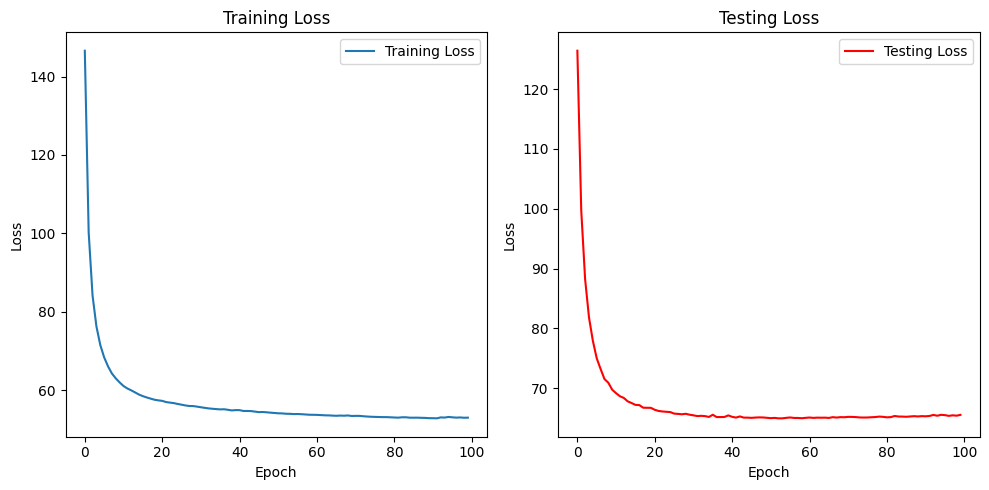

In [21]:
import json
import matplotlib.pyplot as plt

data_dict = {
    "training_loss_FishLeg": training_loss_FishLeg,
    "testing_loss_FishLeg": testing_loss_FishLeg
}

with open('loss_data_FishLeg.json', 'w') as f:
    json.dump(data_dict, f)

# Retrieve data from the JSON file
with open('loss_data_FishLeg.json', 'r') as f:
    loaded_data = json.load(f)

# Plot the data
plt.figure(figsize=(10, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(loaded_data['training_loss_FishLeg'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot testing loss
plt.subplot(1, 2, 2)
plt.plot(loaded_data['testing_loss_FishLeg'], label='Testing Loss', color='red')
plt.title('Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()
